In [1]:
#导入相应的包
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#定义逻辑函数
def logisticFunction(w,X):
    return 1/(1+np.e**(np.dot(X,np.transpose(w))*-1))

In [3]:
#定义损失函数
def logistic_costFunction(w,X,y):
    temp=y*np.log(logisticFunction(w,X))+(1-y)*np.log(1-logisticFunction(w,X));
    #乘以负一，因为由似然函数求最大值转换为求最小值
    return np.sum(temp*-1)/y.shape[0]


In [4]:
#定义梯度函数
def logistic_w_gradient(w,X,y):
    h=logisticFunction(w,X);
    temp=h-y
    gradient=temp*X;
    return gradient

In [5]:
#定义准确率函数
def logistic_predict(w,X,y):
    predict=logisticFunction(w,X);
    predict[predict<0.5]=-1;
    predict[predict>=0.5]=1
    cost = np.sum(np.abs(y - predict)) / 2
    return 1-cost/y.shape[0]

In [6]:
#随机选取小样本
def random_sample(X,y,m):
    X_random=[]
    y_random=[]
    for i in range(m):
        np.random.seed(i);
        index=int(np.random.rand()*X.shape[0])
        X_random.append(X[index])
        y_random.append(y[index])
    return np.array(X_random),np.array(y_random)

In [7]:
def logisticRegression(train_file,test_file):
    #读取文件
    X_train,y_train_origin=load_svmlight_file(train_file)
    X_test,y_test_origin=load_svmlight_file(test_file,n_features=123)
    #稀疏矩阵转ndarray
    X_train=X_train.toarray().astype(float)
    X_test=X_test.toarray().astype(float)
    #保证y的shape
    y_train_origin=np.reshape(y_train_origin,(y_train_origin.shape[0],1))
    y_test_origin=np.reshape(y_test_origin,(y_test_origin.shape[0],1))
    #将y从-1,+1变回为0，+1
    y_train=(y_train_origin+1)/2
    y_test=(y_test_origin+1)/2
    #添加一列全1,提供给b
    X_b=np.ones(X_train.shape[0])
    X_train=np.c_[X_b,X_train]
    X_b=np.ones(X_test.shape[0])
    X_test=np.c_[X_b,X_test]

    #不同算法的rate是不一样的，所以后面会有调整
    rate=0.1
    iteration_time = [] #迭代次数   
    #NAG
    NAG_test_loss_value = [] #测试数据的loss值
    #rmseprop
    RMSEprop_test_loss_value = [] #测试数据的loss值
    #Adadelta
    Adadelta_test_loss_value = [] #测试数据的loss值
    #Adam
    Adam_test_loss_value = [] #测试数据的loss值
    
    print("begin")
    #######################NAG##########################
    #初始化参数
    w=np.zeros((1,X_train.shape[1]))
    #学习率
    rate=0.01
    #动量参数
    u=0.8
    #动量
    v=0
    for i in range(1000):
        #随机批量梯度
        X_train_random,y_train_random=random_sample(X_train,y_train,2000)
        gradient = logistic_w_gradient(w - u * v, X_train_random, y_train_random)
        gradient = np.sum(gradient, axis=0) / gradient.shape[0]
        v = u * v + rate * gradient;
        w = w - v
        NAG_test_loss_value.append(logistic_costFunction(w,X_test,y_test))
        iteration_time.append(i+1) 
    print("NAG准确率")
    print(logistic_predict(w,X_test,y_test_origin))
    ######################RMSEprop##########################
        #初始化参数
    w=np.zeros((1,X_train.shape[1]))
    rate=0.001#如果rate太大，会跳过最小值，再某个数值之间来回波动
    u=0.8#权重参数
    r=0#指数加权移动平均变量
    theta=0.000001#稳定常数
    for i in range(1000):
        X_train_random, y_train_random = random_sample(X_train, y_train, 2000)
        gradient = logistic_w_gradient(w, X_train_random, y_train_random)
        gradient = np.sum(gradient, axis=0) / gradient.shape[0]
        r=u*r+(1-u)*(gradient**2);
        w=w-(rate/np.sqrt(theta+r))*gradient;
        RMSEprop_test_loss_value.append(logistic_costFunction(w,X_test,y_test)) 
    print("RMSEprop准确率")
    print(logistic_predict(w,X_test,y_test_origin))
    ######################Adadelta##########################
    #初始化参数
    w=np.zeros((1,X_train.shape[1]))
    s=0#对gradient指数加权移动平均变量
    u=0.8#权重参数
    delta=0#对s指数加权移动平均变量
    theta=0.000001#稳定常数
    for i in range(1000):
        X_train_random, y_train_random = random_sample(X_train, y_train, 2000)

        gradient = logistic_w_gradient(w, X_train_random, y_train_random)
        gradient = np.sum(gradient, axis=0) / gradient.shape[0]
        s=u*s+(1-u)*(gradient**2);
        g=(np.sqrt(delta+theta)/np.sqrt(s+theta))*gradient
        delta=u*delta+(1-u)*(g**2)
        w=w-g
        Adadelta_test_loss_value.append(logistic_costFunction(w,X_test,y_test))
    print("Adadelta准确率")
    print(logistic_predict(w,X_test,y_test_origin))
    #######################Adam##########################
    #初始化参数
    v=0
    w=np.zeros((1,X_train.shape[1]))
    p1=0.9#动量参数
    p2=0.999#指数加权参数
    theta=0.00000001#稳定常数
    s=0
    step=0#次数
    rate=0.001
    for i in range(1000):
        step+=1
        X_train_random, y_train_random = random_sample(X_train, y_train, 2000)
        gradient = logistic_w_gradient(w, X_train_random, y_train_random)
        gradient = np.sum(gradient, axis=0) / gradient.shape[0]
        v=p1*v+(1-p1)*gradient;
        s=p2*s+(1-p2)*(gradient**2)
        v_=v/(1-p1**step)
        s_=s/(1-p2**step)
        w=w-rate*v_/(np.sqrt(s_)+theta)
        Adam_test_loss_value.append(logistic_costFunction(w,X_test,y_test))
    print("Adam准确率")
    print(logistic_predict(w,X_test,y_test_origin))        
    plt.plot(iteration_time, NAG_test_loss_value , label='NAGTraining Loss')
    plt.plot(iteration_time, RMSEprop_test_loss_value,label='RMSEpropTraining Loss')
    plt.plot(iteration_time, Adadelta_test_loss_value,label='AdadeltapropTraining Loss')
    plt.plot(iteration_time, Adam_test_loss_value,label='AdamTraining Loss')
    plt.title('loss')
    plt.legend()
    plt.show()
    
        

begin
NAG准确率
0.838830538665
RMSEprop准确率
0.847675204226
Adadelta准确率
0.847429519071
Adam准确率
0.841287390209


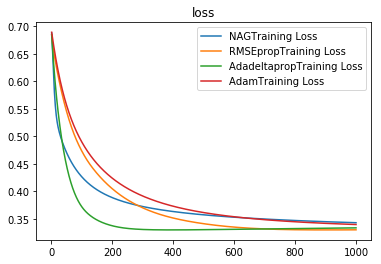

In [12]:
logisticRegression("a9a","a9at")